# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 17 09:23:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1D:00.0 Off |                  Off |
| 33%   30C    P8     3W / 230W |      0MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 236.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# !pip install scipy==1.1.0

### Importing necessary libraries

In [5]:
import numpy as np, pandas as pd
import os
import imageio
# from scipy.misc import imread, imresize
import datetime
import warnings
warnings.filterwarnings("ignore")

In [6]:
import matplotlib.pyplot as plt, seaborn as sns
import glob
import cv2
from skimage import io
import pathlib
import PIL

#### We set the random seed so that the results don't vary drastically.

In [7]:
# Run this cell 2 times if it throws error on first run

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [8]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
batch_size = 16 #experiment with the batch size

In [9]:
train_doc_df= pd.read_csv('/datasets/Project_data/train.csv', sep=';', header=None)
train_doc_df.columns= ['image_name','gesture','label']
train_doc_df.head()

,image_name,gesture,label
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0


<AxesSubplot:xlabel='label', ylabel='count'>

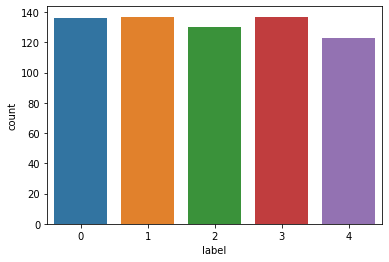

In [10]:
sns.countplot(train_doc_df['label'])

- Its a fairly balances dataset.

In [11]:
print(len(train_doc))
print(len(val_doc))

663
100


In [12]:
DATASET_PATH = '/datasets/Project_data'


In [13]:
# Defining the path for train and val images

data_dir_train = pathlib.Path("/datasets/Project_data/train")
data_dir_val = pathlib.Path("/datasets/Project_data/val")

### Visualization of random images
- We have written code to visualize 16 random images

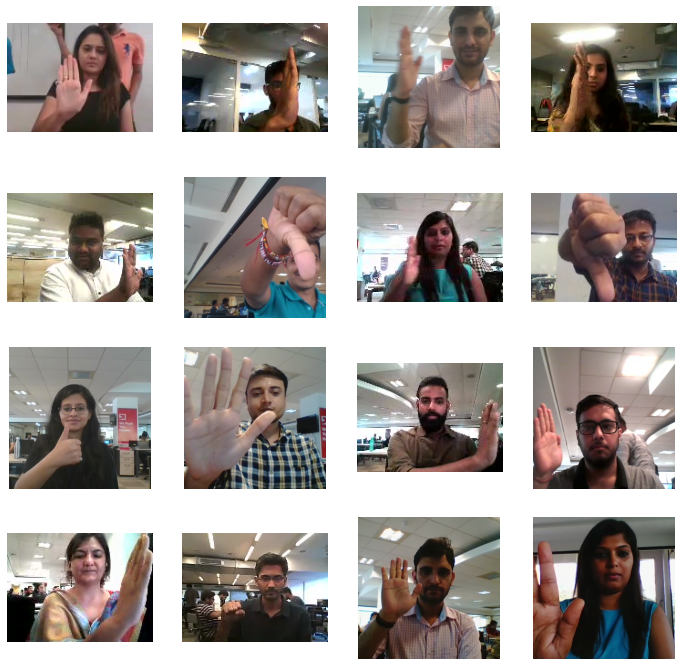

In [14]:
import random
from PIL import Image 

images = []
for folder in os.listdir(data_dir_train):
  for image in os.listdir(str(data_dir_train) + '/' + folder):
    images.append(os.path.join(data_dir_train, folder, image))

plt.figure(1, figsize=(12, 12))
plt.axis('off')
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = imageio.imread(random_img)
  plt.subplot(4, 4, n)
  plt.axis('off')
  plt.imshow(imgs)

plt.show()


In [15]:
img_idx = [0,1,2,4,6,8,10,12,13,14,16,17,18,20,22,24,26,27,28,29]

## Generator
- This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. 
- We have chosen img_idx as 20 (experimented with 17,18,20), y,z as 100,100 respectively and normalization that gives a good accuracy
- we experimented with (128,128) before finalizing (100,100)


In [16]:
def Generator(source_path, folder_list, batch_size):
  print('source_path = ',source_path, 'batch_size = ', batch_size)
  img_idx = [0,1,2,4,6,8,10,12,13,14,16,17,18,20,22,24,26,27,28,29]
  #img_idx = [x for x in range(0,30,2)]

  while True:
    t = np.random.permutation(folder_list)
    # calculating number of batches
    num_batches = len(folder_list)// batch_size
    for batch in range(num_batches):
      # we iterate over the number of batches
      # We have chosen y and z to be 100 and 100 after doing some checks with higher resolution images which were throwing memory error
      batch_data = np.zeros((batch_size, len(img_idx), 100,100,3))
      # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
      batch_lables = np.zeros((batch_size, 5))
      # batch_labels is the one hot representation of the output
      for folder in range(batch_size):
        imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): 
          image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
          #Image is resized using opencv library to 100 x 100 pixels
          image_resized = cv2.resize(image, (100, 100))
          
          #Normalization using the /255 technique since it is RGB images

          batch_data[folder,idx,:,:,0] = image_resized[:, : , 0]/255
          batch_data[folder,idx,:,:,1] = image_resized[:, : , 1]/255
          batch_data[folder,idx,:,:,2] = image_resized[:, : , 2]/255
        
        batch_lables[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
      yield batch_data, batch_lables
    # calculating remainder balance sequences
    seq_left = len(folder_list) % batch_size
    batch +=1
    if(seq_left!=0):
      batch_data = np.zeros((seq_left,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
      batch_labels = np.zeros((seq_left,5)) # batch_labels is the one hot representation of the output
      for folder in range(seq_left):
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
        for idx,item in enumerate(img_idx):
          image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
          #Image is resized using opencv library to 100 x 100 pixels
          image_resized = cv2.resize(image, (100, 100))
          
                    #Normalization using the /255 technique since it is RGB images

          batch_data[folder,idx,:,:,0] = image_resized[:, : , 0]/255
          batch_data[folder,idx,:,:,1] = image_resized[:, : , 1]/255
          batch_data[folder,idx,:,:,2] = image_resized[:, : , 2]/255
                    
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
      yield batch_data, batch_labels






In [17]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40
print ('# epochs =', num_epochs)
print('# lenghth of img_idx =', len(img_idx))

# training sequences = 663
# validation sequences = 100
# epochs = 40
# lenghth of img_idx = 20


# Creating models
## 1. Model using Conv3D

#### Importing necessary libraries for creating the model

In [18]:
from keras.models import Sequential, Model
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [19]:
# img_idx = [x for x in range(0,30,2)]
# len(img_idx)

#previously tried using this range

In [20]:
model1 = Sequential()


model1.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same', input_shape=(20,100,100,3)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model1.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model1.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model1.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(5, activation='softmax'))

2022-08-17 09:23:18.197850: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-17 09:23:18.197934: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [21]:
sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 100, 100, 128  10496     
                             )                                   
                                                                 
 batch_normalization (BatchN  (None, 20, 100, 100, 128  512      
 ormalization)               )                                   
                                                                 
 activation (Activation)     (None, 20, 100, 100, 128  0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 50, 100, 128)  0        
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 50, 100, 256)  8

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
#Create generator objects for train and val

train_generator = Generator(train_path, train_doc, batch_size)
val_generator = Generator(val_path, val_doc, batch_size)

In [23]:
#Model name is given in this format
model_name_1 = 'model_init_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#Check if model exists or not in the directory, if not create it
if not os.path.exists(model_name_1):
    os.mkdir(model_name_1)

#Put more formatting
filepath = model_name_1 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Using callbacks reduce lr on plateau method 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [24]:
#Calculating the steps per epoch for both training sequences and val sequences
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [25]:
#Fit the generator
model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source_path =  /datasets/Project_data/train batch_size =  16
Epoch 1/40


2022-08-17 09:23:20.596013: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 2.7840 - categorical_accuracy: 0.3529source_path =  /datasets/Project_data/val batch_size =  16

Epoch 00001: val_loss improved from inf to 1.91130, saving model to model_init_1_2022-08-1709_23_17.447981/model-00001-2.78401-0.35294-1.91130-0.16000.h5
42/42 [==============================] - 65s 1s/step - loss: 2.7840 - categorical_accuracy: 0.3529 - val_loss: 1.9113 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/40
42/42 [==============================] - ETA: 0s - loss: 1.3630 - categorical_accuracy: 0.4842
Epoch 00002: val_loss did not improve from 1.91130
42/42 [==============================] - 51s 1s/step - loss: 1.3630 - categorical_accuracy: 0.4842 - val_loss: 2.7382 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/40
42/42 [==============================] - ETA: 0s - loss: 1.1766 - categorical_accuracy: 0.5053
Epoch 00003: val_loss did not improve from 1.91130

Epoch 00003: ReduceLROnPlateau reducing learn

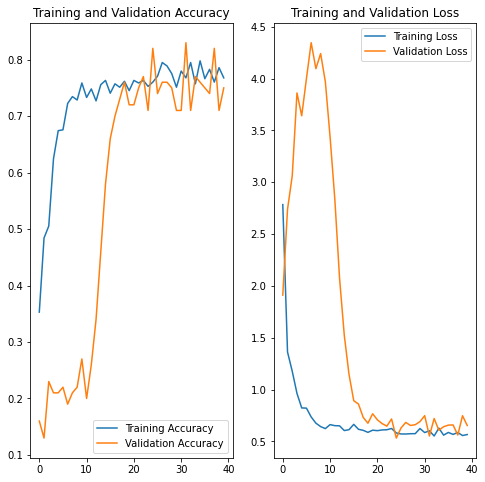

In [36]:
acc = model1.history.history['categorical_accuracy']
val_acc = model1.history.history['val_categorical_accuracy']

loss = model1.history.history['loss']
val_loss = model1.history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 1. Model using Conv2D + RNN
- In our case we will be using GRU instead of LSTM because of its lighter arcitecture 

In [27]:
#Select the number of target variables as 5 since we have 5 gestures
num_classes = 5

#Create a keras model using sequential
model2 = Sequential()

#Start with 16 filters with 3 x 3 and the input shape as 20 x 100 x 100 x 3
model2.add(TimeDistributed(Conv2D(16, (3, 3), padding='same'), input_shape = (20,100,100,3 )))

#Using relu activation function
model2.add(TimeDistributed(Activation('relu')))
#Doing batch normalization
model2.add(TimeDistributed(BatchNormalization()))
#Add Max 2D pooling layer
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))


#Add another layer with 32 filters
model2.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
model2.add(TimeDistributed(Activation('relu')))

model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))


#Add another layer with 62 filters
model2.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
model2.add(TimeDistributed(Activation('relu')))

model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#Add a dropout layer
model2.add(TimeDistributed(Dropout(0.25)))


#Add another layer with 128 filters
model2.add(TimeDistributed(Conv2D(128, (3, 3), padding='same')))
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))

model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))


#Add another layer with 256 filters

model2.add(TimeDistributed(Conv2D(256, (3, 3), padding='same')))
model2.add(TimeDistributed(Activation('relu')))
model2.add(TimeDistributed(BatchNormalization()))

model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#Addd a dropout layer
model2.add(TimeDistributed(Dropout(0.25)))


#Add a flatten layer with all the parameters
model2.add(TimeDistributed(Flatten()))


model2.add(Dropout(0.5))
#Add a GRU layer for our sequential model
model2.add(GRU(128, return_sequences=True))
model2.add(Dense(32,activation ='relu'))
model2.add(Dropout(0.5))
model2.add(Flatten())
#Add a softmax layer for prediction of the 5 classes
model2.add((Dense(num_classes, activation='softmax')))


In [28]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 100, 100, 16)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 50, 50, 32)  

In [29]:
sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [30]:
#Create generator objects for train and val

train_generator = Generator(train_path, train_doc, batch_size)
val_generator = Generator(val_path, val_doc, batch_size)

In [31]:
#Model name is given in this format
model_name_2 = 'model_init_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#Check if model exists or not in the directory, if not create it
if not os.path.exists(model_name_2):
    os.mkdir(model_name_2)

#Put more formatting
filepath = model_name_2 + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Using callbacks reduce lr on plateau method 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [32]:
# The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
#FIt the model and check the accuracy
model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source_path =  /datasets/Project_data/train batch_size =  16
Epoch 1/40
42/42 [==============================] - ETA: 0s - loss: 1.8115 - categorical_accuracy: 0.2323source_path =  /datasets/Project_data/val batch_size =  16

Epoch 00001: val_loss improved from inf to 1.62389, saving model to model_init_2_2022-08-1709_23_17.447981/model-00001-1.81155-0.23228-1.62389-0.21000.h5
42/42 [==============================] - 43s 969ms/step - loss: 1.8115 - categorical_accuracy: 0.2323 - val_loss: 1.6239 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/40
42/42 [==============================] - ETA: 0s - loss: 1.6142 - categorical_accuracy: 0.2609
Epoch 00002: val_loss did not improve from 1.62389
42/42 [==============================] - 41s 987ms/step - loss: 1.6142 - categorical_accuracy: 0.2609 - val_loss: 2.0936 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/40
42/42 [==============================] - ETA: 0s - loss: 1.5460 - categorical_accuracy: 0.3213
Epoch 00003: val_lo

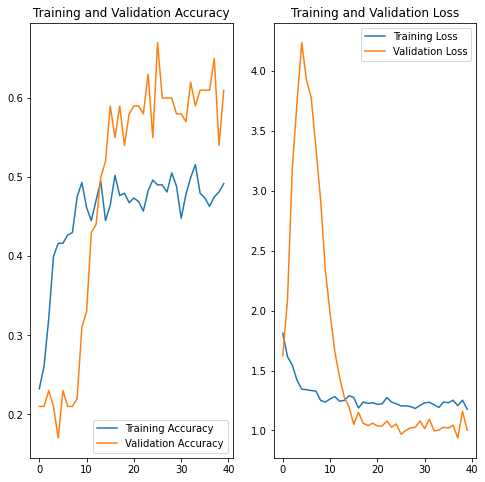

In [34]:
acc = model2.history.history['categorical_accuracy']
val_acc = model2.history.history['val_categorical_accuracy']

loss = model2.history.history['loss']
val_loss = model2.history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()